In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
import pickle
import tensorflow as tf
# from keras import backend as K
import tensorflow as tf

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Training Model

In [3]:
# load the data

curr_path = "/content/drive/MyDrive/Senior/Spring/EECSC106B/FinalProject/"
sys.path.append(os.path.abspath(curr_path))

cat = np.load(curr_path + 'data/cat.npy')
sheep = np.load(curr_path + 'data/sheep.npy')
giraffe = np.load(curr_path + 'data/giraffe.npy')
bat = np.load(curr_path + 'data/bat.npy')
octopus = np.load(curr_path + 'data/octopus.npy')
camel = np.load(curr_path + 'data/camel.npy')
print(cat.shape)
print(sheep.shape)
print(giraffe.shape)
print(bat.shape)
print(octopus.shape)
print(camel.shape)

(123202, 784)
(126121, 784)
(127182, 784)
(118114, 784)
(150152, 784)
(121399, 784)


In [4]:
#add a column for labels
cat = np.c_[cat, np.zeros(len(cat))]
giraffe = np.c_[giraffe, np.ones(len(giraffe))]
sheep = np.c_[sheep, 2*np.ones(len(sheep))]
bat = np.c_[bat, 3*np.ones(len(bat))]
octopus = np.c_[octopus, 4*np.ones(len(octopus))]
camel = np.c_[camel, 5*np.ones(len(camel))]
print(cat.shape)

(123202, 785)


In [5]:
#make sure data was imported and stored correctly
def plot_samples(input_array, rows=4, cols=5, title=''):
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

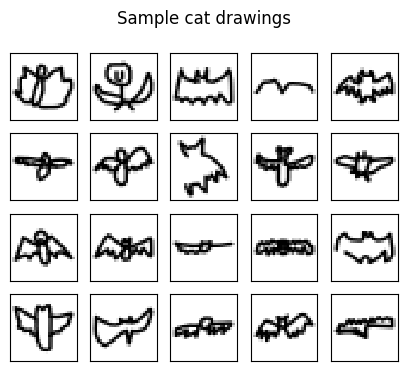

In [20]:
plot_samples(bat, title='Sample cat drawings\n')

In [7]:
# Merging arrays and splitting the features and labels
y = np.concatenate((cat[:10000,-1], giraffe[:10000,-1], sheep[:10000,-1], bat[:10000,-1], octopus[:10000,-1],  camel[:10000,-1]), axis=0).astype('float32') # the last column
X = np.concatenate((cat[:10000,:-1], giraffe[:10000,:-1], sheep[:10000,:-1], bat[:10000,:-1], octopus[:10000,:-1], camel[:10000, :-1]), axis=0).astype('float32') # all columns but the last

# Split data between train and test (80 - 20 ratio). Normalizing the value between 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.2,random_state=0)

In [8]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [9]:
print(X_train_cnn.shape)
print(X_test_cnn.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)


In [10]:
#create CNN model
def cnn_model():
    # create model
    model = Sequential()
    model.call = tf.function(model.call)
    model.add(Conv2D(30, (3, 3), input_shape=(28, 28,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

In [17]:
# Run the function
make_keras_picklable()

In [33]:
%%time
np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Fit the model
# model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=15, batch_size=200)
model_cnn.fit(X_train_cnn, y_train_cnn)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

1500/1500 [==============================] - 8s 4ms/step - loss: 0.5587 - accuracy: 0.8063
Final CNN accuracy:  0.8880833387374878
CPU times: user 9.3 s, sys: 652 ms, total: 9.95 s
Wall time: 12.9 s


In [12]:
# y_pred_cnn = model_cnn.predict(X_test_cnn, verbose=0)
y_pred_cnn = np.argmax(model_cnn.predict(X_test_cnn), axis=-1)
c_matrix = metrics.confusion_matrix(y_test, y_pred_cnn)


375/375 [==============================] - 1s 2ms/step


In [13]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

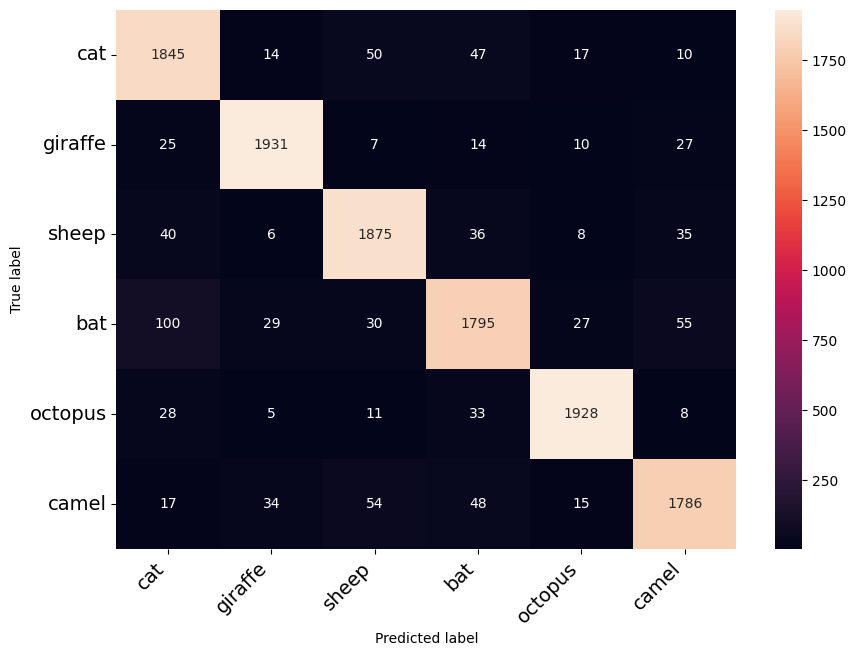

In [14]:
class_names = ['cat', 'giraffe', 'sheep', 'bat', 'octopus', 'camel']
confusion_matrix(c_matrix, class_names, figsize = (10,7), fontsize=14)

In [121]:
#save model
# save_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")
# model_cnn.save(curr_path, options=save_option)
with open(curr_path + 'model_cnn.pkl', 'wb') as file:
      pickle.dump(model_cnn, file)

In [15]:
# import pickle

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
# import flask
# from flask import Flask,render_template,url_for,request
import base64
import numpy as np
import cv2
import tensorflow as tf
# from tensorflow.python.keras.backend import set_session
from matplotlib import image
from skimage.color import rgb2gray
from skimage import io  

In [137]:
# with open(curr_path + 'model_cnn.pkl', 'rb') as f:
#   model = pickle.load(f)

TypeError: ignored

In [126]:
# img = io.imread(curr_path + 'img/octopus.jpg')
# gray_image = rgb2gray(img) 
# resized = cv2.resize(gray_image, (28,28), interpolation = cv2.INTER_AREA)
# # print(resized.dtype)
# # print(resized.shape)
# vect = np.asarray(resized, dtype="uint8")
# # print(vect.dtype)
# # print(vect.shape)
# vect = vect.reshape(1, 28, 28, 1).astype('float32')
# plt.imshow(gray_image, cmap=plt.cm.gray)
# plt.show()
            # resized = cv2.resize(image, (28,28), interpolation = cv2.INTER_AREA)
            # vect = np.asarray(resized, dtype="uint8")
            # vect = vect.reshape(1, 1, 28, 28).astype('float32')

Using Model with Flask App

In [31]:
#labels that we can predict
labels = {0:'Cat', 1:'Giraffe', 2:'Sheep', 3:'Bat', 4:'Octopus', 5:'Camel'}

#tf_config = some_custom_config
# sess = tf.compat.v1.Session()

#initialize graph
# graph = tf.compat.v1.get_default_graph()
# tf.compat.v1.disable_eager_execution()

# #load trained CNN model
# with open(curr_path + 'model_cnn.pkl', 'rb') as f:
#         model = pickle.load(f)
      
def predict(image_input):
        # global graph
        # with graph.as_default():
            #Load model
            # with open(curr_path + 'model_cnn.pkl', 'rb') as f:
            #   model = pickle.load(f)
            final_pred = None

            #Preprocessing
            img = io.imread(curr_path + 'img/' + image_input)
            gray_image = rgb2gray(img) 
            plt.imshow(gray_image, interpolation='nearest')
            plt.show()
            resized = cv2.resize(gray_image, (28,28), interpolation = cv2.INTER_AREA)
            plt.imshow(resized, interpolation='nearest')
            plt.show()
            vect = np.asarray(resized, dtype="uint8")
            plt.imshow(vect, interpolation='nearest')
            plt.show()
            vect = vect.reshape(1, 28, 28, 1).astype('float32')
            
            #predict the label
            # set_session(sess)
            my_prediction = model_cnn.predict(vect)
            print(my_prediction)
            index = np.argmax(my_prediction[0])
            #Associating the index and its value within the dictionnary
            final_pred = labels[index]

            return final_pred

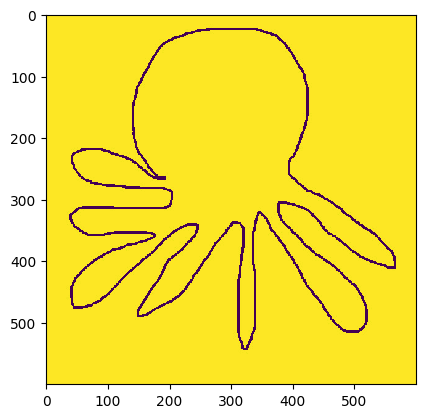

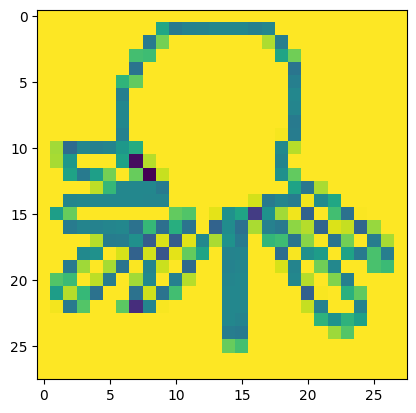

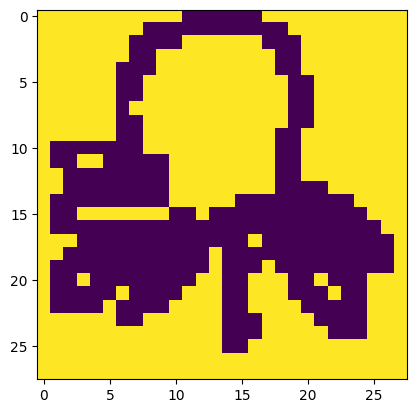

1/1 [==============================] - 0s 165ms/step
[[0.17213798 0.00399067 0.02359333 0.77601457 0.01330023 0.01096315]]
Bat


In [34]:
print(predict('octopus.jpg'))

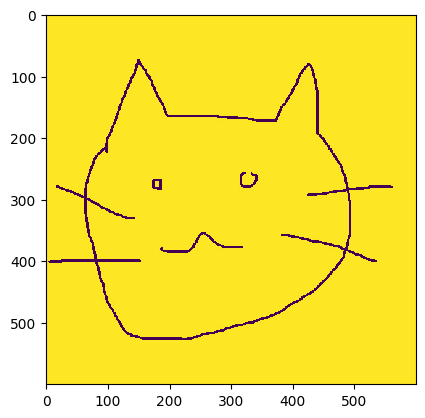

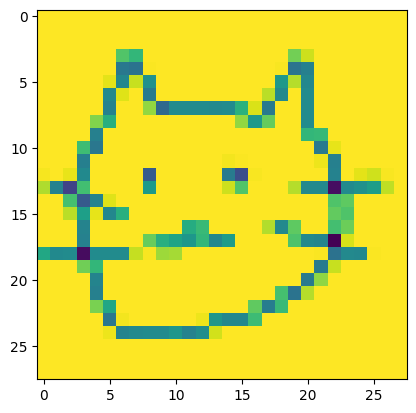

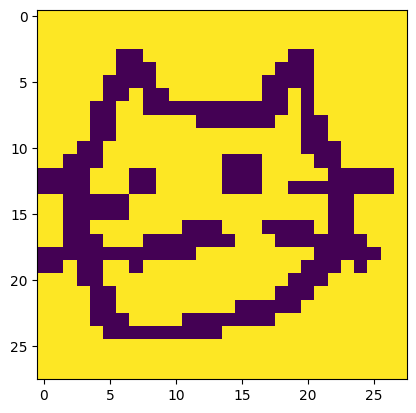

1/1 [==============================] - 0s 19ms/step
Cat


In [18]:
print(predict('cat.jpg'))

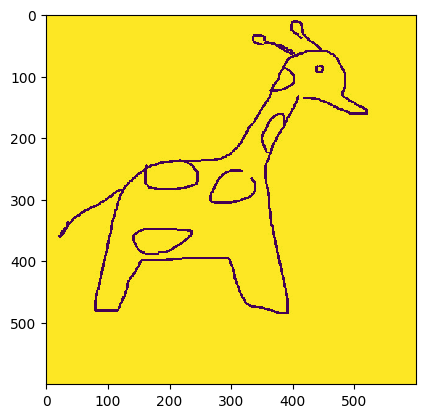

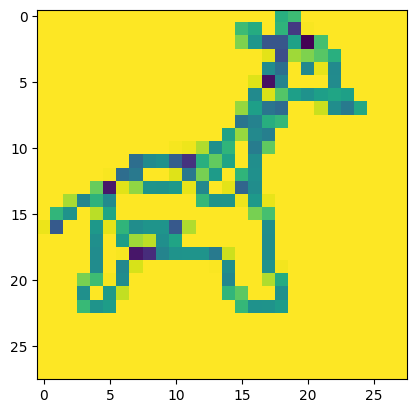

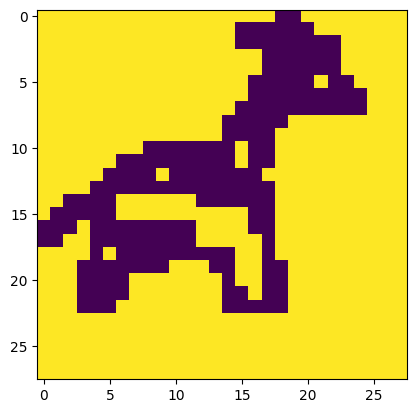

1/1 [==============================] - 0s 20ms/step
Cat


In [19]:
print(predict('giraffe.jpg'))

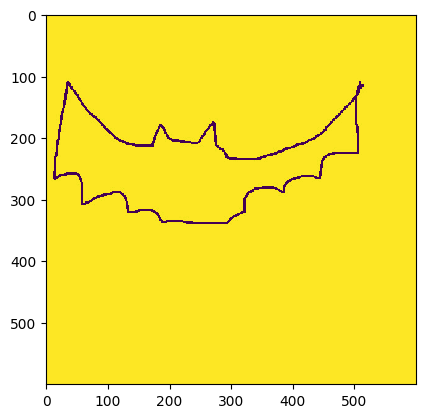

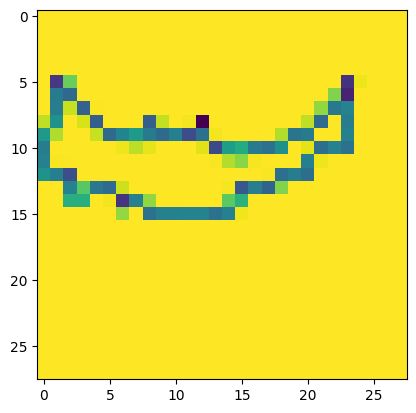

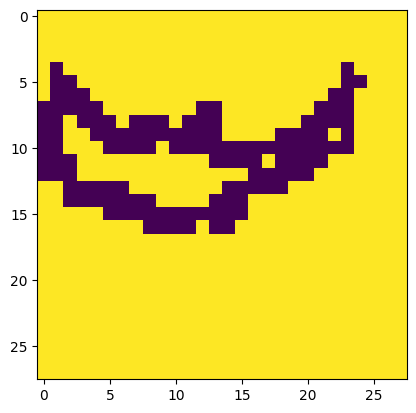

1/1 [==============================] - 0s 27ms/step
Cat


In [23]:
print(predict('bat.jpg'))

In [27]:
X_train_cnn[86].shape, y_train_cnn[86]

((28, 28, 1), array([0., 0., 1., 0., 0., 0.], dtype=float32))

In [30]:
model_cnn.predict(X_train_cnn[86].reshape(1, 28, 28, 1).astype('float32'))

1/1 [==============================] - 0s 34ms/step


array([[1.1692749e-04, 1.5687932e-05, 9.9965811e-01, 6.3911459e-05,
        7.6943606e-06, 1.3773523e-04]], dtype=float32)